The data extraction notebook was about extracting all the relevant features from the dataset
We have extracted MFCCs and spectral centroids for 7994/8000 tracks
Now we will apply treatments to these features, starting by dimensionality reduction and clustering

In [2]:
# Make imports
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure


C:\Users\jibbzed\AppData\Local\Temp\ipykernel_41644\2687164998.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


We have 2 dataframes to load : the features extracted from the tracks, and the metadata about the tracks (namely the genre)

In [3]:
# Load the data into dataframes
features = pd.read_csv('data/extracted_features.csv')
metadata = pd.read_csv('data/metadata.csv')

# Remove the tracks that were not found in the features dataset from the metadata
metadata = metadata[metadata['track_id'].isin(features['track_id'])]

print (metadata.shape)
print (features.shape)

(7994, 4)
(7994, 148)


We will first try to reduce the dimensionality of our data from 148 to just 2 in order to be able to visualize the data points
Then we'll apply a simple K-means clustering (and it's even better because we know the expected numebr of clusters) on our data to see how it does
Note that reducing the dimensionality from 148 to 2 will lead to massive loss and therefore the clustering might not be great
We could (and will probably) also reduce the dimensionality to a bit more like 10 features, apply a K-means and evaluate it by comparing the clusters to the real values for the genre (the evaluation will be a bit of a pain) 
In order to find the best number of dimensions we can apply PCA to all features (not reducing anything) and checking the contributions from the different attributes to the PCA
Note that for the data to be mapped we need to have the dataframes ordered in the same way : the first element of the metadata corresponds to the same track as the first element of the features dataframe
For this, it is possible to merge the two dataframes in oder to have all in one

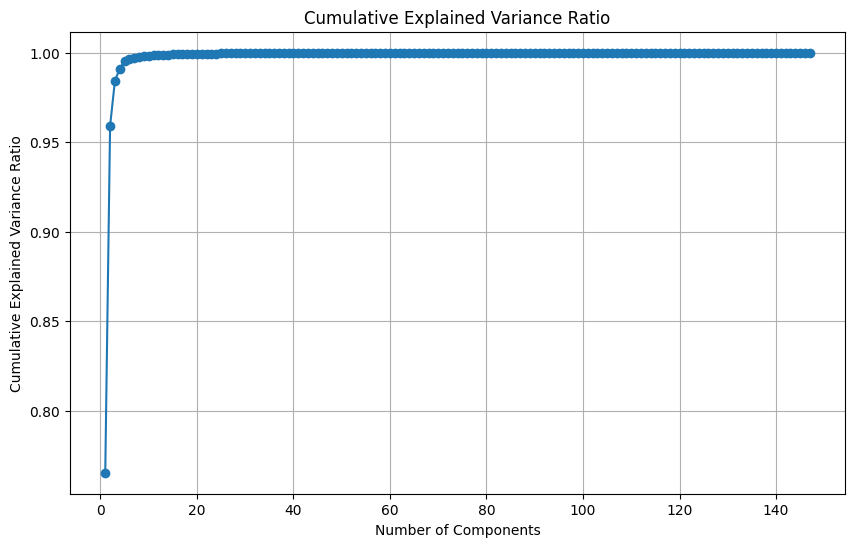

array([ True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [4]:
# Drop the track_id column first
X = features.drop(columns=['track_id']).values

# Dimensionality reduction (PCA)
pca = PCA(n_components=X.shape[1])  # Keep all components initially
X_pca = pca.fit_transform(X)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

cumulative_explained_variance_ratio < 0.99

As we can see, 95% of the variance can be explained with 1 component, and 99% with 3, so 2 components is enough for our use case especially because it allows us to visualise the data
Now that we have our clusters, we can evaluate them, not visually but mathematically speaking

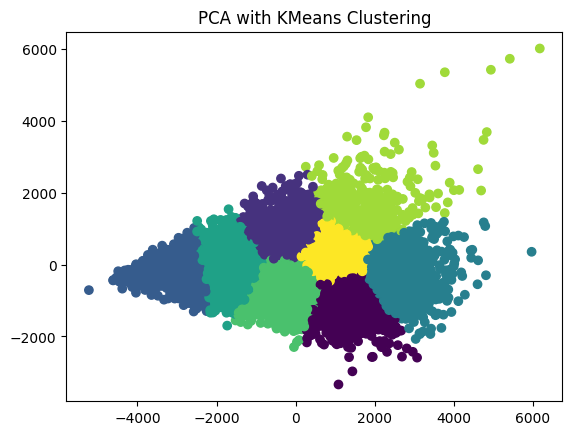

In [5]:
# Dimensionality reduction using PCA
# First, reducing to 2 dimensions for visualization

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering using KMeans with 8 clusters because we know that there are 8 genres
n_clusters = 8
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit(X_pca)

# Visualize the clusters
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters.labels_)
plt.title('PCA with KMeans Clustering')
plt.show()


Even with only 2 components for PCA the Kmeans yields a very good result as we can see on the graph
The fact that the clusters are very well defined means that it should be pretty easy to classify the data and also that the features we extracted are relevant !
I will however try to check how many dimensions should be kept and try PCA with that

In [6]:
# Evaluate clustering performance
true_labels = metadata['track_genre'].values

silhouette = silhouette_score(X_pca, clusters.labels_)
ari = adjusted_rand_score(true_labels, clusters.labels_)
nmi = normalized_mutual_info_score(true_labels, clusters.labels_)
h, c, v = homogeneity_completeness_v_measure(true_labels, clusters.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Homogeneity: {h}")
print(f"Completeness: {c}")
print(f"V-measure: {v}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")

Silhouette Score: 0.3395452625580105
Homogeneity: 0.10255950218224145
Completeness: 0.10475639173040024
V-measure: 0.10364630693298321
Adjusted Rand Index (ARI): 0.06050798058134105
Normalized Mutual Information (NMI): 0.10364630693298323


#TODO : analyse the results of the clustering
Let's interpret each of the evaluation metrics based on the provided values:

Silhouette Score: 0.3391077082648229
This indicates moderate clustering quality. A silhouette score between 0.25 and 0.5 suggests that the clusters are reasonably well-separated.
The value of 0.3391 indicates that the average distance between samples in the same cluster is larger than the distance between samples in different clusters, which is a positive sign.

Homogeneity: 0.10329527639929258
This value indicates low homogeneity, suggesting that the clusters are not very pure. It means that the clusters contain samples from multiple classes, rather than being composed mostly of samples from a single class.

Completeness: 0.10502800921333921
Similarly to homogeneity, the low completeness value suggests that each class is not entirely assigned to a single cluster. Some samples from each class might be spread across multiple clusters.

V-measure: 0.10415443678756468
V-measure is the harmonic mean of homogeneity and completeness. The low value indicates that neither homogeneity nor completeness is high, resulting in a relatively low overall V-measure.

Adjusted Rand Index (ARI): 0.06081721484810713
This value suggests a slightly better than random clustering performance. ARI ranges from -1 to 1, where 1 indicates perfect clustering agreement with the ground truth labels, 0 indicates random clustering, and negative values indicate clustering worse than random.

Normalized Mutual Information (NMI): 0.10415443678756468
NMI measures the mutual information between the true and predicted cluster labels, normalized by the total entropy of the labels. The low value suggests limited mutual information between the true and predicted labels, indicating that the clustering algorithm does not capture the true label information well.

In summary, the provided metrics indicate that while there is some structure in the clustering, it is not strong. The clusters are moderately separated according to the silhouette score, but they are not very homogeneous or complete. The ARI and NMI scores suggest that the clustering does not agree strongly with the ground truth labels. These results indicate that there may be room for improvement in the clustering algorithm or in the data preprocessing steps.

We can try with 5 dimensions for clustering and see how it affects the metrics (because with 5 dimensions we have more than 99% of the variance explained)

In [7]:
# Perform PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Clustering using KMeans with 8 clusters because we know that there are 8 genres
n_clusters = 8
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit(X_pca)

# We can't visualize the clusters

# Evaluate clustering performance
silhouette = silhouette_score(X_pca, clusters.labels_)
ari = adjusted_rand_score(true_labels, clusters.labels_)
nmi = normalized_mutual_info_score(true_labels, clusters.labels_)
h, c, v = homogeneity_completeness_v_measure(true_labels, clusters.labels_)

print(f"Silhouette Score: {silhouette}")
print(f"Homogeneity: {h}")
print(f"Completeness: {c}")
print(f"V-measure: {v}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Normalized Mutual Information (NMI): {nmi}")

Silhouette Score: 0.2918608257147961
Homogeneity: 0.10454227747934702
Completeness: 0.10656834242390813
V-measure: 0.1055455877046808
Adjusted Rand Index (ARI): 0.06107445483790582
Normalized Mutual Information (NMI): 0.10554558770468077


The results are almost the same, even a bit worse it seems like, so we will just stick with our 2 components
Either way once we get to the classification task we won't be using PCA anymore, we will probably use all the features for our classifiers => this can be discussed, how many parameters we give to the model can affect the performances

Now that we have done the clustering part, we can start the actual classification task
We will train two different models namely SVM and Random Forest (debatable but those are the ones I choose, we could compare them to a neural network of some kind)
The data has already been split in 3 sets for us, and the sets are supposedly very well balanced in order to make our lives easier, so we will start by getting our 3 sets and then we will train our models, using cross validation and the validation set to tune the hyperparameters

In [8]:
# Split our dataset in 3 parts: train, validation and test  

# First, we need to merge the features and metadata dataframes
data = pd.merge(features, metadata, on='track_id')

# Split the data into train, validation and test sets
train = data[data['set'] == 'training']
validation = data[data['set'] == 'validation']  
test = data[data['set'] == 'test']

# Sanity check
print(train.shape)
print(validation.shape)
print(test.shape)

# Drop the track_id, track_genre, genre_id and set columns
X_train = train.drop(columns=['track_id', 'track_genre', 'set', 'genre_id']).values
X_validation = validation.drop(columns=['track_id', 'track_genre', 'set', 'genre_id']).values
X_test = test.drop(columns=['track_id', 'track_genre', 'set', 'genre_id']).values

# Split the data into data and labels, labels being the track_genre column
y_train = train['track_genre'].values
y_validation = validation['track_genre'].values
y_test = test['track_genre'].values

# Sanity check
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

(6394, 151)
(800, 151)
(800, 151)
(6394, 147)
(800, 147)
(800, 147)
(6394,)
(800,)
(800,)


Tried using GridSearch in order to automate the hyperparameter tuning process
The idea is that it performs 5 fold cross validation with all possible combinations of hyperparameters that is given to it, and ends up outputting the best performing model
Note that because I use cross validation I should merge the training and validation datasets because the validation is done "on the training data" with cross validation
We could also try to use PCA before inputing the data so that the training becomes quicker, especially because we have seen that the variance in the dataset can be explained mostly with 2 or 3 dimensions instead of 147

In [ ]:
# First we want to train SVM model with 5 fold cross validation
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Merge the train and validation sets for cross validation
X_cross_validation = np.concatenate((X_train, X_validation))
y_cross_validation = np.concatenate((y_train, y_validation))

'''
# Use PCA to reduce the dimensionality of the data
pca = PCA(n_components=5)
X_cross_validation = pca.fit_transform(X_cross_validation)
X_test = pca.transform(X_test)
'''

# Be sure training samples are shuffled.
X_cross_validation, y_cross_validation = skl.utils.shuffle(X_cross_validation, y_cross_validation, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_cross_validation)
scaler.transform(X_test)

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=5)

# Fit the model
grid.fit(X_cross_validation, y_cross_validation)

# Print the best parameters
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
#print(grid.best_index_)
#print(grid.scorer_)
#print(grid.n_splits_)
#print(grid.refit_time_)
#print(grid.cv_results_)

# Make predictions
y_pred = grid.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

Even using PCA, the training still takes a lot of time, therefore it might not be worth it
The results are a bit worse with PCA than without and the training time is not that much reduced, so just keep everything ?
Note that we use a rbf kernel for the SVM because the problem at hand is quite complex and the rbf kernel allows us to find non linear relationships in the data

In [10]:
# Let's now try to train a Random Forest model
from sklearn.ensemble import RandomForestClassifier

'''
# Use PCA to reduce the dimensionality of the data
pca = PCA(n_components=5)
X_cross_validation = pca.fit_transform(X_cross_validation)
X_test = pca.transform(X_test)
'''

# Define the parameter grid
param_grid = {'n_estimators': [10, 100, 1000], 'max_features': ['auto', 'sqrt', 'log2']}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, cv=5)

# Fit the model
grid.fit(X_cross_validation, y_cross_validation)

# Print the best parameters
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
#print(grid.best_index_)
#print(grid.scorer_)
#print(grid.n_splits_)
#print(grid.refit_time_)
#print(grid.cv_results_)

# Make predictions
y_pred = grid.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END ..max_features=auto, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END .max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END max_features=auto, n_estimators=1000;, score=nan total time=   0.0s
[CV 2/5] END max_features=auto, n_estimators=1000

d:\Cours\Echange Milan\Audio Pattern Recognition\music-genre-recognition\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Cours\Echange Milan\Audio Pattern Recognition\music-genre-recognition\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Cours\Echange Milan\Audio Pattern Recognition\music-genre-recognition\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "d:\Cours\Echange Mi

{'max_features': 'sqrt', 'n_estimators': 1000}
RandomForestClassifier(n_estimators=1000)
0.5176536595785398
               precision    recall  f1-score   support

   Electronic       0.47      0.56      0.51       100
 Experimental       0.32      0.18      0.23       100
         Folk       0.19      0.21      0.20       100
      Hip-Hop       0.54      0.61      0.57       100
 Instrumental       0.38      0.46      0.42       100
International       0.46      0.48      0.47       100
          Pop       0.30      0.24      0.27       100
         Rock       0.58      0.58      0.58       100

     accuracy                           0.41       800
    macro avg       0.41      0.41      0.41       800
 weighted avg       0.41      0.41      0.41       800



Using PCA reduces the training time by almost half which is pretty good, but the accuracy of the model is not the best (less than 30% instead of 40)

Seeing that the performance are not that great using an SVM, we could think that the features we extracted are not enough and that we need more
The performances for the RandomForest are quite good though => we get to about 40% accuracy against 25% for the SVM, but WHY ?
Note that we could possibly reduce the number of estimators max from 1000 to for example 500 because training with 1000 estimators takes a lot of time (thankfully we only have 5 fold cross validation so 5*1:30 is not too too bad), but the 1000 estimators don't seem to give way better performances so is it really worth it ?
We can either make a new extraction with more features, like chroma vector, ... or use the ones given in the dataset
Either way, we could compare how the "full feature" and "small number of features" classifiers perform

After correcting the mistake made on the SVM training (not normalizing the data), the SVM gets to about 40% accuracy, which is about 5% less than with the "large" dataset, proving that the larger dataset makes a difference, but not that big
For Random Forest though, the change between dataset is of the order of 2%, which is quite low
That could mean that Random Forest is "better" as in more stable or that the extracted features are more suitable for a random forest model and the extra features make little to no difference

Last thing to do is to retry using the PCA with the corrected SVM training to see if the effects are still the same
=> it seems like PCA and shuffling/normalizing don't mix very well (which I beleive kind of makes sense because you lose the relative importance of the principal components over one another) and gives very very poor results when used with SVM, on the large and small datasets (12% accuracy, basically random)